In [1]:
#导入数据
import pandas as pd
ori_pre_data=pd.read_csv('ori_pre_data.csv')
ori_train_data=pd.read_csv('ori_train_data.csv')
rent_data=pd.read_csv('rent_data.csv')
detail_data=pd.read_csv('detail_data.csv')

In [2]:
#导入相应的包

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cn2an
import datetime
from collections import Counter
import jieba
from sklearn import metrics
from dateutil.parser import parse
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder



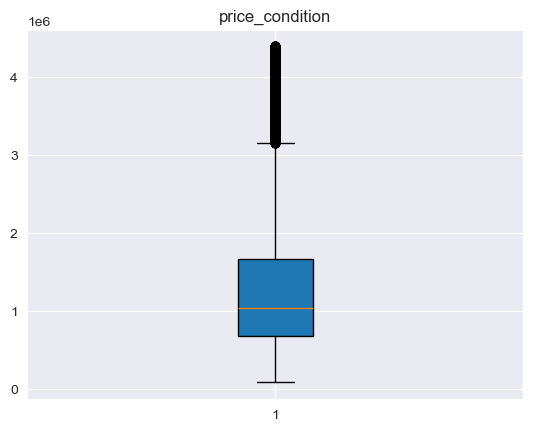

In [35]:
plt.boxplot(ori_train_data['价格'], vert=True, patch_artist=True)
plt.title("price_condition")
plt.show()

In [3]:
#剔除价格异常值，根据四分位数筛选异常价格
print(f"原始数据量: {len(ori_train_data)}")
Q1=ori_train_data['价格'].quantile(0.25)
Q3=ori_train_data['价格'].quantile(0.75)
IQR = Q3 - Q1
low_bound=Q1 - 1.5*IQR
high_bound=Q3 + 1.5*IQR
full_data_train=ori_train_data[(ori_train_data['价格']>=low_bound)&(ori_train_data['价格']<=high_bound)]
# 展示删除结果
print(f"清洗后数据量: {len(full_data_train)}")

原始数据量: 84133
清洗后数据量: 75927


In [4]:
#对面积进行处理
#将面积转化为float
ori_pre_data["建筑面积"] = ori_pre_data['建筑面积'].str.replace(r'[^\d.]', '', regex=True)
ori_pre_data["建筑面积"]=pd.to_numeric(ori_pre_data["建筑面积"], errors='coerce')

full_data_train["建筑面积"] = full_data_train['建筑面积'].str.replace(r'[^\d.]', '', regex=True)
full_data_train["建筑面积"]=pd.to_numeric(full_data_train["建筑面积"], errors='coerce')
#对面积进行正态化，采用boxcox
from scipy import stats
mjbocxoc,extra = stats.boxcox(full_data_train['建筑面积'])
#sns.kdeplot(mjbocxoc, fill=True, bw_adjust=0.5, color='blue')
#sns.kdeplot(fulldata["建筑面积"], fill=True, bw_adjust=0.5, color='blue')
full_data_train['建筑面积_boxcox']=mjbocxoc


#利用核密度函数，删除异常值（5%）
from scipy.stats import gaussian_kde
area_col = full_data_train['建筑面积_boxcox']
kde = gaussian_kde(area_col)
density = kde.evaluate(area_col)
threshold = np.quantile(density, 0.05)
valid_mask = density >= threshold
ori_train_data2 = full_data_train[valid_mask].copy().reset_index(drop=True)
# 展示删除结果
print(f"原始数据量: {len(full_data_train)}, 清洗后数据量: {len(ori_train_data2)}")

#合并训练预测数据集
ori_train_data=ori_train_data2.drop(columns=['建筑面积_boxcox'])
fulldata = pd.concat([ori_train_data, ori_pre_data], axis=0)

#对整个合并的数据集的面积正态化
mjbocxoc,extra = stats.boxcox(fulldata['建筑面积'])
#sns.kdeplot(mjbocxoc, fill=True, bw_adjust=0.5, color='blue')
#sns.kdeplot(fulldata["建筑面积"], fill=True, bw_adjust=0.5, color='blue')
fulldata['建筑面积_boxcox']=mjbocxoc
fulldata=fulldata.drop(columns=['建筑面积'])


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_12720\1277519247.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_data_train["建筑面积"] = full_data_train['建筑面积'].str.replace(r'[^\d.]', '', regex=True)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_12720\1277519247.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_data_train["建筑面积"]=pd.to_numeric(full_data_train["建筑面积"], errors='coerce')
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_12720\1277519247.py:13: SettingWithCopyWarning: 
A value is trying to 

原始数据量: 75927, 清洗后数据量: 72130


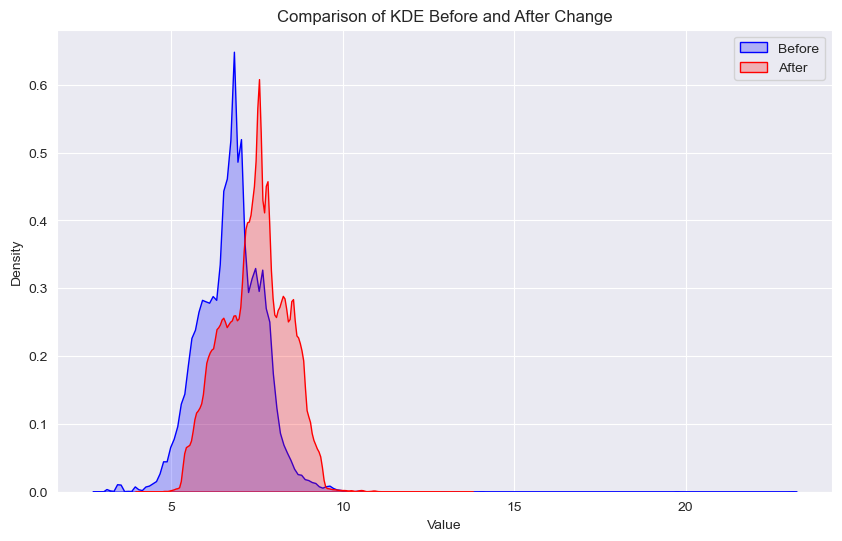

In [39]:
plt.figure(figsize=(10, 6))
sns.kdeplot(full_data_train['建筑面积_boxcox'], label='Before', color='blue',fill=True, bw_adjust=0.5)
sns.kdeplot(fulldata['建筑面积_boxcox'], label='After', color='red',fill=True, bw_adjust=0.5)
plt.title('Comparison of KDE Before and After Change')
plt.xlabel('Value')
plt.ylabel('Density_s')
plt.legend()
plt.show()

In [5]:
fulldata['区域'].value_counts()

区域
93.0    6051
65.0    5549
59.0    3833
53.0    3491
46.0    3329
        ... 
8.0        3
16.0       2
10.0       2
75.0       1
63.0       1
Name: count, Length: 94, dtype: int64

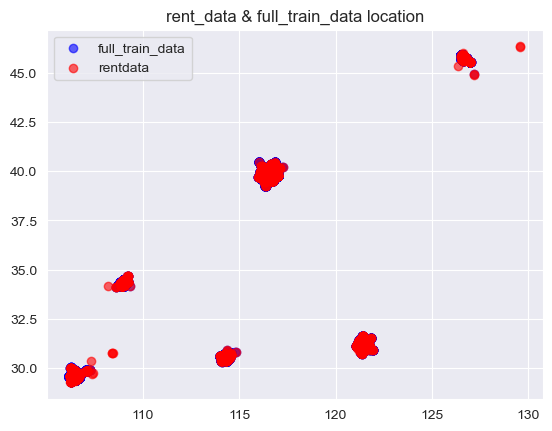

In [6]:
#detail数据集坐标与生活成本列生成
#观察坐标关系
fig, ax = plt.subplots()
ax.scatter(ori_train_data['lon'], ori_train_data['lat'], color='blue', label='full_train_data', alpha=0.6)
ax.scatter(detail_data['coord_x'], detail_data['coord_y'], color='red', label='rentdata',alpha=0.6)
ax.legend()
plt.title("rent_data & full_train_data location")
plt.show()

In [7]:
#检查缺失值
detail_data.isnull().sum()

区县            1
名称            0
城市            0
板块            5
环线位置       1298
小区地址          0
物业类别          0
建筑年代        188
开发商         524
房屋总数          0
楼栋总数          0
物业公司        655
绿 化 率       386
容 积 率       383
物 业 费       356
建筑结构        143
物业办公电话     2123
产权描述          2
供水          187
供暖          734
供电          170
燃气费         432
供热费        1865
停车位         554
停车费用        435
coord_x       0
coord_y       0
dtype: int64

In [8]:
#detail数据集的数据处理
#转为数字
detail_data["物 业 费"] = detail_data['物 业 费'].str.replace(r'[^\d.]', '', regex=True)
detail_data["物 业 费"]=pd.to_numeric(detail_data["物 业 费"], errors='coerce')

detail_data["燃气费"] = detail_data['燃气费'].str.replace(r'[^\d.]', '', regex=True)
detail_data["燃气费"]=pd.to_numeric(detail_data["燃气费"], errors='coerce')
#填充缺失值
median_wuye=detail_data['物 业 费'].median()
median_ranqi=detail_data['燃气费'].median()
detail_data['物 业 费']=detail_data['物 业 费'].fillna(median_wuye)
detail_data['燃气费']=detail_data['燃气费'].fillna(median_ranqi)
#生活成本列生成
detail_data['价格']=12*detail_data['物 业 费']+detail_data['燃气费']
detail_data['lon']=detail_data['coord_x']
detail_data['lat']=detail_data['coord_y']

In [9]:
from sklearn.cluster import KMeans
#合并成full_detail
detail_loc=detail_data[['lon','lat','价格']].copy()
detail_loc_price=fulldata[['lon','lat','价格']].copy()
full_detail=pd.concat([detail_loc, detail_loc_price], axis=0)
# 聚类，假设分为30类
kmeans = KMeans(n_clusters=30, random_state=42)
full_detail['cluster'] = kmeans.fit_predict(full_detail[['lon', 'lat']])
#独热编码
one_hot = pd.get_dummies(full_detail['cluster'], prefix='Cluster')

# 合并到原始DataFrame
full_loc = pd.concat([full_detail, one_hot], axis=1)
#拟合detail的数据，给fulldata新的一列一个基于生活成本的预测值
detail_xtrain=full_detail[:3100].drop(columns=['价格'])
detail_ytrain=full_detail[:3100]['价格']
detail_pre=full_detail[3100:].drop(columns=['价格'])
#线性回归模型
from sklearn.linear_model import LassoCV
from sklearn import metrics
alphas2 = np.array([1e-5, 5e-5, 0.0001, 0.0005])
lassoCV = LassoCV(alphas=alphas2, max_iter=1000, cv=6).fit(detail_xtrain, detail_ytrain)
#生成生活成本预测
fulldata['detail_pre'] = lassoCV.predict(detail_pre)
fulldata['detail_pre']=fulldata['detail_pre'].fillna(fulldata['detail_pre'].median())
#对数正态化
fulldata['detail_pre']=np.log(fulldata['detail_pre'])

C:\Users\Lenovo\miniconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


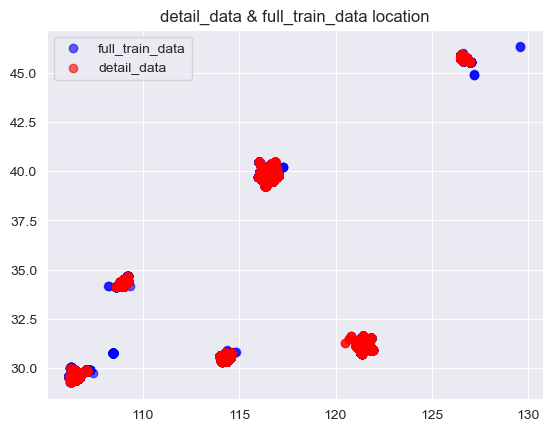

In [10]:
#坐标处理数据，rent数据集
#观察数据分布
fig, ax = plt.subplots()
ax.scatter(fulldata['lon'], fulldata['lat'], color='blue', label='full_train_data', alpha=0.6)
ax.scatter(rent_data['lon'], rent_data['lat'], color='red', label='detail_data',alpha=0.6)
ax.legend()
plt.title("detail_data & full_train_data location")
plt.show()

In [11]:
from sklearn.cluster import KMeans
#将rent和dfulldata的坐标和价格合并为full_loc
rent_loc=rent_data[['lon','lat','价格']].copy()
buy_loc=fulldata[['lon','lat','价格']].copy()
full_loc=pd.concat([rent_loc, buy_loc], axis=0)
# 聚类，假设分为30类(15
kmeans = KMeans(n_clusters=30, random_state=42)
full_loc['cluster'] = kmeans.fit_predict(full_loc[['lon', 'lat']])
#独热编码
one_hot = pd.get_dummies(full_loc['cluster'], prefix='Cluster')

# 合并到原始DataFrame
full_loc = pd.concat([full_loc, one_hot], axis=1)
#用rent的数据训练，预测dataframe的结果
loc_xtrain=full_loc[:84150].drop(columns=['价格'])
loc_ytrain=full_loc[:84150]['价格']
loc_pre=full_loc[84150:].drop(columns=['价格'])
#预测
alphas2 = np.array([1e-5, 5e-5, 0.0001, 0.0005])
lassoCV = LassoCV(alphas=alphas2, max_iter=1000, cv=6).fit(loc_xtrain, loc_ytrain)
fulldata['rent_pre'] = lassoCV.predict(loc_pre)
#对数正态化
fulldata['rent_pre']=np.log(fulldata['rent_pre'])

#填充fulldata
fulldata = pd.concat([fulldata, one_hot[84150:]], axis=1)


C:\Users\Lenovo\miniconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 518141441658.4855, tolerance: 131127916.5318139
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Lenovo\miniconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 518317395993.65454, tolerance: 131127916.5318139
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Lenovo\miniconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 518330889808.6212, tolerance: 131127916.5318139
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Lenovo\miniconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.p

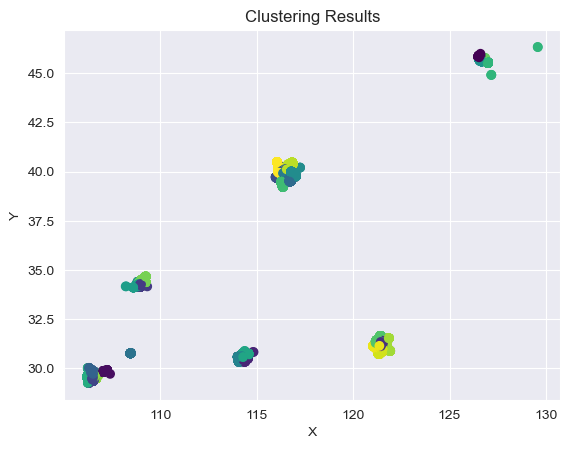

In [12]:
#展示聚类结果

import matplotlib.pyplot as plt

plt.scatter(fulldata['lon'], fulldata['lat'], c=full_loc['cluster'][84150:], cmap='viridis')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Clustering Results')
plt.show()

fulldata=fulldata.drop(columns=['lon','lat'])

In [13]:
#fulldata数据处理
#梯户比例处理
#将梯户比例分解
middledf = fulldata["梯户比例"].str.split('梯', expand=True)
# 重命名新列
middledf.columns = [f'{i}' for i in ["梯数","户数"]]
# 合并到原DataFrame
fulldata = pd.concat([fulldata, middledf], axis=1)
fulldata.drop(columns=["梯户比例"], inplace=True)
fulldata['户数']=fulldata['户数'].str.replace('户','')
#转化为数字
fulldata['户数']=fulldata['户数'].fillna("零")
fulldata['户数'] = fulldata['户数'].apply(lambda x: cn2an.cn2an(x, 'normal'))
fulldata['梯数']=fulldata['梯数'].fillna("一百")
fulldata['梯数'] = fulldata['梯数'].apply(lambda x: cn2an.cn2an(x, 'normal'))
fulldata['梯户比']=fulldata['户数']/fulldata['梯数']
THrate_m=fulldata['梯户比'].median()
fulldata['梯户比']=fulldata['梯户比'].replace(0,THrate_m)
fulldata=fulldata.drop(columns=['梯数','户数'])
#正态化
fulldata["梯户比"]=np.log(fulldata["梯户比"])


#房屋户型处理
pattern = r'(?P<室>\d+)室?.*?(?P<厅>\d+)厅?.*?(?P<厨>\d+)厨?.*?(?P<卫>\d+)卫?'
fulldata[['室', '厅', '厨', '卫']] = fulldata['房屋户型'].str.extract(pattern, expand=True).fillna(0).astype(int)
#特征工程，用房间的相对数量反应房屋结构
fulldata['总房间数']=fulldata['室']+fulldata['厅']+fulldata['厨']+fulldata['卫']
fulldata['卧总比']=fulldata['室']/fulldata['总房间数']
fulldata['卧卫比']=fulldata['室']/fulldata['卫']
#防止除0导致inf
fulldata["卧总比"]=fulldata.apply(
    lambda row: 0 if (row['总房间数']==0)
                else row['卧总比'],
    axis=1
)

fulldata["卧卫比"]=fulldata.apply(
    lambda row: 0 if (row['卫']==0)
                else row['卧卫比'],
    axis=1
)

fulldata=fulldata.drop(columns=['房屋户型'])

#将所在楼层分解
split_df = fulldata["所在楼层"].str.split('(', expand=True)
# 重命名新列
split_df.columns = [f'{i}' for i in ["楼层区域","楼层总数"]]
# 合并到原DataFrame
fulldata = pd.concat([fulldata, split_df], axis=1)
fulldata.drop(columns=["所在楼层"], inplace=True)
#将楼层总数转化为float
fulldata["楼层总数"] = fulldata['楼层总数'].str.replace(r'[^\d.]', '', regex=True)
fulldata["楼层总数"]=pd.to_numeric(fulldata["楼层总数"], errors='coerce')

#交易时间转化为数字
fulldata['交易时间'] = pd.to_datetime(fulldata['交易时间'], format='%Y-%m-%d')
target_date = pd.to_datetime('2025-01-01')
fulldata['days_diff'] = (target_date - fulldata['交易时间']).dt.days
#删除特定异常值

#年份
fulldata['年份']=2025-fulldata['年份']


In [14]:
#rent数据集有关房屋结构的数据处理——用于在dataframe生成一列基于房屋结构预测的租金列MDH_pre
#rent
#房屋户型处理
pattern = r'(?P<室>\d+)室?.*?(?P<厅>\d+)厅?.*?(?P<卫>\d+)卫?'
rent_data[['室', '厅', '卫']] = rent_data['户型'].str.extract(pattern, expand=True).fillna(0).astype(int)
#特征工程
rent_data['总房间数']=rent_data['室']+rent_data['厅']+rent_data['卫']

rent_data['卧总比']=rent_data['室']/rent_data['总房间数']
rent_data['卧卫比']=rent_data['室']/rent_data['卫']

rent_data["卧总比"]=rent_data.apply(
    lambda row: 0 if (row['总房间数']==0)
                else row['卧总比'],
    axis=1
)

rent_data["卧卫比"]=rent_data.apply(
    lambda row: 0 if (row['卫']==0)
                else row['卧卫比'],
    axis=1
)
#rent面积处理
rent_data["建筑面积_boxcox"] = rent_data['面积'].str.replace(r'[^\d.]', '', regex=True)
rent_data["建筑面积_boxcox"]=pd.to_numeric(rent_data["建筑面积_boxcox"], errors='coerce')
rent_data["建筑面积_boxcox"]=np.log(rent_data["建筑面积_boxcox"])
rent_data=rent_data.drop(columns=['户型','面积'])

#合并成新的数据集
rent_M_D_H=rent_data[['建筑面积_boxcox','室','厅','卫','总房间数','卧总比','卧卫比','价格']].copy()
price_M_D_H=fulldata[['建筑面积_boxcox','室','厅','卫','总房间数','卧总比','卧卫比','价格']].copy()
full_mdh=pd.concat([rent_M_D_H, price_M_D_H], axis=0)

#拆分训练测试
MDH_xtrain=full_mdh[:84150].drop(columns=['价格'])
MDH_ytrain=full_mdh[:84150]['价格']
MDH_pre=full_mdh[84150:].drop(columns=['价格'])

#在fulldata生成新列MDH_pre
alphas2 = np.array([0.005,0.0008, 0.001, 0.0005])
lassoCV = LassoCV(alphas=alphas2, max_iter=1000, cv=6).fit(MDH_xtrain, MDH_ytrain)
fulldata['MDH_pre'] = lassoCV.predict(MDH_pre)
#对数正态化
fulldata['MDH_pre']=np.log(fulldata['MDH_pre'])
fulldata['面积平方']=fulldata['建筑面积_boxcox']*fulldata['建筑面积_boxcox']
fulldata['rent_pre2']=fulldata['rent_pre']*fulldata['rent_pre']

C:\Users\Lenovo\miniconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 67297708773.77026, tolerance: 131127916.5318139
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Lenovo\miniconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 67296998961.37976, tolerance: 131127916.5318139
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Lenovo\miniconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 67296963638.61023, tolerance: 131127916.5318139
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Lenovo\miniconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py

In [15]:
#文本处理
#统计词频——房屋优势
def chinese_word_segment(text):
    words = jieba.lcut(str(text))  # 强制转为字符串避免报错
    return [word for word in words if '\u4e00' <= word <= '\u9fff']  # Unicode汉字范围
# 应用分词并统计
word_list = fulldata['房屋优势'].apply(chinese_word_segment).sum()
word_counts = Counter(word_list)
# 3输出结果
print(word_counts.most_common(10))
target_word = []
for i in range(len(word_counts.most_common(10))):
    target_word.append(word_counts.most_common(10)[i][0])
for target_w in target_word:
    fulldata[f'{target_w}_count'] = fulldata['房屋优势'].str.count(target_w).fillna(0)
fulldata.drop(columns=['房屋优势'])


#统计词频——方向
def chinese_word_segment(text):
    words = jieba.lcut(str(text))  # 强制转为字符串避免报错
    return [word for word in words if '\u4e00' <= word <= '\u9fff']  # Unicode汉字范围
#应用分词并统计
word_list = fulldata['房屋朝向'].apply(chinese_word_segment).sum()
word_counts = Counter(word_list)
#输出结果
print(word_counts.most_common())
direct=[]
for i in range(len(word_counts.most_common())):
    direct.append(word_counts.most_common()[i][0])
for target_w in direct:
    fulldata[f'{target_w}_direct'] = fulldata['房屋朝向'].str.count(target_w).fillna(0)
fulldata.drop(columns=['房屋朝向'])
fulldata['朝向总数']=0
for i in direct:
   fulldata['朝向总数']+=fulldata[f'{i}_direct']

#统计词频——核心卖点
def chinese_word_segment(text):
    words = jieba.lcut(str(text))  # 强制转为字符串避免报错
    return [word for word in words if '\u4e00' <= word <= '\u9fff']  # Unicode汉字范围
#应用分词并统计
word_list = fulldata['核心卖点'].apply(chinese_word_segment).sum()
word_counts = Counter(word_list)
#输出结果
print(word_counts.most_common(30))
#提取前20高频词
sellpoint=[]
for i in range(len(word_counts.most_common(30))):
    sellpoint.append(word_counts.most_common(30)[i][0])
for target_w in sellpoint:
    fulldata[f'{target_w}_count2'] = fulldata['核心卖点'].str.count(target_w).fillna(0)
fulldata.drop(columns=['核心卖点'])

#删除原文本列
fulldata=fulldata.drop(columns=['房屋朝向','房屋优势','核心卖点'])





Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Lenovo\AppData\Local\Temp\jieba.cache
Loading model cost 0.849 seconds.
Prefix dict has been built successfully.


[('房本满', 49437), ('装修', 38764), ('五年', 31461), ('地铁', 30451), ('两年', 17976)]
[('南', 59165), ('北', 33350), ('东南', 10850), ('东', 8229), ('西', 5661), ('西南', 3294), ('西北', 1712), ('东北', 1347)]
[('好', 35085), ('采光', 21864), ('户型', 18252), ('楼层', 17775), ('此房', 16450), ('视野', 14668), ('小区', 13785), ('通透', 10491), ('出售', 10479), ('业主', 10369), ('南北', 10149), ('方正', 10072), ('方便', 9614), ('诚心', 9527), ('配套', 9284), ('交通', 8214), ('精装修', 8156), ('满', 7772), ('唯一', 7535), ('便利', 7503), ('充足', 6815), ('格局', 6175), ('房子', 5955), ('齐全', 5901), ('满五', 5829), ('开阔', 5810), ('中间', 5660), ('装修', 5453), ('五年', 5320), ('精装', 5272)]


In [16]:
#类别变量处理
#填充缺失值_房屋年限
fulldata['房屋年限']=fulldata['房屋年限'].fillna("满五年")
fulldata = pd.get_dummies(fulldata, columns=['房屋年限'], prefix='房屋年限')

#填充配备电梯
fulldata["配备电梯"]=fulldata.apply(
    lambda row: "有" if (pd.isna(row['配备电梯']) and row['楼层总数']>8)
                else "无" if pd.isna(row['配备电梯'])
                else row['配备电梯'],
    axis=1
)
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder(categories=[['无', '有']])
fulldata['配备电梯'] = encoder.fit_transform(fulldata[['配备电梯']])

#填充建筑结构
fulldata['建筑结构']=fulldata['建筑结构'].fillna("未知结构")
fulldata = pd.get_dummies(fulldata, columns=['建筑结构'], prefix='建筑结构')
#填装修情况

fulldata['装修情况']=fulldata['装修情况'].fillna("其他")
fulldata = pd.get_dummies(fulldata, columns=['装修情况'], prefix='装修情况')

#填充房屋用途并化简房屋用途类型
fulldata['房屋用途']=fulldata['房屋用途'].fillna("其他")
top_6 = fulldata['房屋用途'].value_counts().nlargest(6).index
fulldata['房屋用途'] = fulldata['房屋用途'].where(fulldata['房屋用途'].isin(top_6), '其他结构')
fulldata = pd.get_dummies(fulldata, columns=['房屋用途'], prefix='房屋用途')

#将不需要填充的类别变量独热编码
fulldata = pd.get_dummies(fulldata, columns=['产权所属'], prefix='产权所属')
fulldata = pd.get_dummies(fulldata, columns=['交易权属'], prefix='交易权属')
fulldata = pd.get_dummies(fulldata, columns=['楼层区域'], prefix='楼层区域')
fulldata['房间结构健全']=( (fulldata[['室', '厨', '厅', '卫']] != 0).all(axis=1) ).astype(int)
fulldata = pd.get_dummies(fulldata, columns=['城市'], prefix='城市')

#特征工程_朝向个数统计与文本中高频词采光交互项
fulldata['朝向_采光']=fulldata['朝向总数']*fulldata['采光_count2']

#特征工程_房屋位置与是否配备电梯与楼层总数生成交互项
for i in ['底层 ','低楼层 ','中楼层 ','高楼层 ','顶层 ','地下室 ']:
    fulldata[f'方便_{i}']=fulldata[f'楼层区域_{i}']*fulldata['配备电梯']*fulldata['楼层总数']

In [17]:
#删除未处理的列
fulldata=fulldata.drop(columns=["抵押信息","ID","套内面积","户型介绍","别墅类型","周边配套","交通出行","环线","小区名称","板块","区域",'上次交易','交易时间'])

#序列重构
cols_to_move=[]
for i in range(30):
    cols_to_move.append(f'Cluster_{i}')
new_columns = [col for col in fulldata.columns if col not in cols_to_move] + cols_to_move
fulldata = fulldata[new_columns]

In [19]:
#查看数据集
fulldata.info(20)

<class 'pandas.core.frame.DataFrame'>
Index: 86916 entries, 0 to 14785
Data columns (total 153 columns):
 #    Column        Dtype  
---   ------        -----  
 0    价格            float64
 1    配备电梯          float64
 2    年份            float64
 3    建筑面积_boxcox   float64
 4    detail_pre    float64
 5    rent_pre      float64
 6    Cluster_15    bool   
 7    Cluster_16    bool   
 8    Cluster_17    bool   
 9    Cluster_18    bool   
 10   Cluster_19    bool   
 11   Cluster_20    bool   
 12   Cluster_21    bool   
 13   Cluster_22    bool   
 14   Cluster_23    bool   
 15   Cluster_24    bool   
 16   Cluster_25    bool   
 17   Cluster_26    bool   
 18   Cluster_27    bool   
 19   Cluster_28    bool   
 20   Cluster_29    bool   
 21   梯户比           float64
 22   室             int64  
 23   厅             int64  
 24   厨             int64  
 25   卫             int64  
 26   总房间数          int64  
 27   卧总比           float64
 28   卧卫比           float64
 29   楼层总数          int64  

In [20]:
#标准化_将连续型变量标准化，消除量纲结果
from sklearn.preprocessing import StandardScaler
StdSc=StandardScaler()
fulldata['detail_pre']=fulldata['detail_pre'].fillna(fulldata['detail_pre'].median())
full_stand=fulldata.iloc[:,:50]
StdSc=StdSc.fit(full_stand)
fullData_=StdSc.transform(full_stand)
fullData_1=pd.DataFrame(fullData_)
fullData_1.columns = full_stand.columns
fullData_1.head()

#拼接标准化后的连续型变量和类别变量
fullData_2=fulldata.iloc[:,50:]
fullData2=pd.concat([fullData_1.reset_index(), fullData_2.reset_index()], axis=1)
fullData2=fullData2.drop(columns=['index'])



In [21]:
#查看变量与价格的相关性
test=fullData2[0:]
corrDf = test.corr()
#变量太多热力图看不清楚，注释
#plt.figure()
#sns.heatmap(corrDf,cmap=plt.cm.RdBu,linecolor='white',annot=True)
corrDf['价格'].map(abs).sort_values(ascending =False)

价格            1.000000
rent_pre2     0.719876
rent_pre      0.717731
城市_0          0.588372
Cluster_8     0.395010
                ...   
房屋用途_其他结构     0.002126
西北_direct     0.001523
东北_direct     0.001235
房屋年限_满两年      0.000817
Cluster_11         NaN
Name: 价格, Length: 153, dtype: float64

In [22]:
#选取相关性大于0.005的列
cols = corrDf['价格'][abs(corrDf['价格'])>0.0001].index
fullNew = fullData2[cols]
sum_train=fullNew.drop(columns=['价格'])
#划分训练预测集位置
train_X=sum_train[:72130]
train_Y=fulldata['价格'][:72130]
predict_X=sum_train[72130:]
#划分训练集与测试集
from sklearn.model_selection import train_test_split
X_train_0, X_test_0, y_train, y_test = train_test_split(train_X, train_Y, test_size=0.2, random_state=111)

In [23]:
#检查每列数据是否有无穷大等异常值
for col in train_X.columns:
    if train_X[col].isin([np.inf, -np.inf]).any():
        print(f"列【{col}】存在无穷大")
        # 输出具体行号
        inf_rows = train_X.index[train_X[col].isin([np.inf, -np.inf])].tolist()
        print(f"异常行号：{inf_rows}")

# 检查超float64范围的值
max_float = np.finfo(np.float64).max
out_of_range = train_X.apply(lambda x: x.abs() > max_float)
if out_of_range.any().any():
    print("存在超过float64范围的值")

In [24]:
#lassco回归
from sklearn.linear_model import LassoCV
from sklearn import metrics
alphas2 = np.array([1e-5, 0.0006, 0.0007, 0.0005])
lassoCV = LassoCV(alphas=alphas2, max_iter=1000, cv=6).fit(X_train_0, y_train)
y_pred = lassoCV.predict(X_test_0)
print("Root mean square error (RMSE):", np.sqrt(metrics.mean_squared_error(y_test,y_pred)))
print(lassoCV.alpha_)


C:\Users\Lenovo\miniconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4207581214658254.5, tolerance: 3969367037241.637
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Lenovo\miniconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4207285696554486.0, tolerance: 3969367037241.637
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Lenovo\miniconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4207057863400870.0, tolerance: 3969367037241.637
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Lenovo\miniconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent

Root mean square error (RMSE): 422781.260808453
1e-05


C:\Users\Lenovo\miniconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.002e+15, tolerance: 4.764e+12
  model = cd_fast.enet_coordinate_descent(


In [25]:
#ElasticNet回归
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error
from sklearn import metrics
#alphas2 = np.array([0.003, 0.0005,0.001])
alphas2 = np.linspace(0.0000001, 0.0005, 20)
l1_ratios = np.linspace(0.7, 1, 20)
elasticNetCV = ElasticNetCV(alphas=alphas2, l1_ratio=l1_ratios, max_iter=1000, cv=6).fit(X_train_0, y_train)
y_pred = elasticNetCV.predict(X_test_0)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)

C:\Users\Lenovo\miniconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4220857782649669.5, tolerance: 3969367037241.637
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Lenovo\miniconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4219982238245166.5, tolerance: 3969367037241.637
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Lenovo\miniconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4219237740620367.0, tolerance: 3969367037241.637
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Lenovo\miniconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent

RMSE: 422781.26082529617


C:\Users\Lenovo\miniconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.002e+15, tolerance: 4.764e+12
  model = cd_fast.enet_coordinate_descent(


In [26]:
from sklearn.linear_model import ElasticNet
#提交预测结果
y_final=elasticNetCV.predict(predict_X)
house_id=ori_pre_data['ID']
submission = pd.DataFrame({'id': house_id , 'price': y_final})

submission.to_csv('house_pred.csv', index=False)

In [27]:
#指标验证
#insample
y_pred_insample = elasticNetCV.predict(X_train_0)
rmse = np.sqrt(mean_squared_error(y_train, y_pred_insample))
print("MAE_in sample:", rmse)
mae_lin=metrics.mean_absolute_error(y_train,y_pred_insample)
print("MAE_in sample:", mae_lin)
#outsample
y_pred_outsample = elasticNetCV.predict(X_test_0)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_outsample))
print("RMSE_out sample:", rmse)
mae_lin=metrics.mean_absolute_error(y_test,y_pred_outsample)
print("MAE_out sample:", mae_lin)

MAE_in sample: 416384.97626819584
MAE_in sample: 290477.94217031414
RMSE_out sample: 422781.26082529617
MAE_out sample: 292860.42636974785


In [28]:
#OLS线性回归
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
linreg = LinearRegression()
linreg.fit(X_train_0, y_train)
#in sample
y_pred_lin = linreg.predict(X_train_0)
rmse_lin = np.sqrt(mean_squared_error(y_train, y_pred_lin))
print("RMSE_insample_lin:", rmse_lin)
mae_lin=metrics.mean_absolute_error(y_train,y_pred_lin)
print("MAE_insample_lin:", mae_lin)
#out of sample
y_pred_lin = linreg.predict(X_test_0)
rmse_lin = np.sqrt(mean_squared_error(y_test, y_pred_lin))
print("RMSE_outsample_lin:", rmse_lin)
mae_lin=metrics.mean_absolute_error(y_test,y_pred_lin)
print("MAE_outsample_lin:", mae_lin)

#交叉验证
from sklearn.model_selection import cross_val_score
param_grid = {
    'fit_intercept': [True, False],
    'positive': [True, False]
}

# 初始化网格搜索器
linreg = LinearRegression()
grid_search = GridSearchCV(
    estimator=linreg,
    param_grid=param_grid,
    cv=6,
    scoring='neg_mean_squared_error',
    n_jobs=-1  # 并行加速
)

# 执行搜索并获取最优模型
grid_search.fit(X_train_0, y_train)
best_model = grid_search.best_estimator_

y_pred_lin = best_model.predict(X_train_0)
rmse_lin = np.sqrt(mean_squared_error(y_train, y_pred_lin))
print("RMSE_cv_lin:", rmse_lin)
y_pred_lin = best_model.predict(X_test_0)
mae_lin=metrics.mean_absolute_error(y_test,y_pred_lin)
print("MAE_cv_lin:", mae_lin)

y_final=best_model.predict(predict_X)
house_id=ori_pre_data['ID']
submission = pd.DataFrame({'id': house_id , 'price': y_final})

submission.to_csv('house_pred_lin.csv', index=False)

RMSE_insample_lin: 415556.9333033704
MAE_insample_lin: 290080.6630338876
RMSE_outsample_lin: 421173.88768220984
MAE_outsample_lin: 291990.1707921579
RMSE_cv_lin: 415556.93330337165
MAE_cv_lin: 291990.170792226


In [29]:
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge

# rig_insample
rr = Ridge(alpha=0.001)
rr.fit(X_train_0, y_train)
y_pred_rr = rr.predict(X_train_0)
print("RMSE_insample_rig:", np.sqrt(metrics.mean_squared_error(y_train,y_pred_rr)))
print("MAE_insample_rig:", metrics.mean_absolute_error(y_train, y_pred_rr))

#rig_ousanple
y_pred_rr = rr.predict(X_test_0)
print("RMSE_outsample_rig:", np.sqrt(metrics.mean_squared_error(y_test,y_pred_rr)))
print("MAE_outsample_rig:", metrics.mean_absolute_error(y_test, y_pred_rr))

#rig_cv
alphas = [0.005, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 80]
ridgeCV = RidgeCV(alphas=alphas, cv=6).fit(X_train_0, y_train)
y_pred_rid = ridgeCV.predict(X_test_0)
print("RMSE_cv_rig:", np.sqrt(metrics.mean_squared_error(y_test,y_pred_rid)))
print("MAE_cv_rig:", metrics.mean_absolute_error(y_test, y_pred_rid))

#提交
y_final=ridgeCV.predict(predict_X)
house_id=ori_pre_data['ID']
submission = pd.DataFrame({'id': house_id , 'price': y_final})

submission.to_csv('house_pred_rig.csv', index=False)

RMSE_insample_rig: 415811.8623441785
MAE_insample_rig: 290211.7213520953
RMSE_outsample_rig: 421791.1823419655
MAE_outsample_rig: 292307.2965180949
RMSE_cv_rig: 422000.9322672338
MAE_cv_rig: 292417.29336760635


In [30]:
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso

# lasso_insample
lassor = Lasso(alpha=0.0001)
lassor.fit(X_train_0, y_train)
y_pred_lasso = lassor.predict(X_train_0)
print("RMSE_insample_lasso:", np.sqrt(metrics.mean_squared_error(y_train,y_pred_lasso)))
print("MAE_insample_lasso:", metrics.mean_absolute_error(y_train, y_pred_lasso))

#lasso_ousanple
y_pred_lasso = lassor.predict(X_test_0)
print("RMSE_outsample_lasso:", np.sqrt(metrics.mean_squared_error(y_test,y_pred_lasso)))
print("MAE_outsample_lasso:", metrics.mean_absolute_error(y_test, y_pred_lasso))

#lasso_cv
alphas2 = np.array([1e-5, 5e-5, 0.0001, 0.0005])
lassoCV = LassoCV(alphas=alphas2, max_iter=5000, cv=6).fit(X_train_0, y_train)
y_pred_lasso = lassoCV.predict(X_test_0)
print("RMSE_cv_lasso:", np.sqrt(metrics.mean_squared_error(y_test,y_pred_lasso)))
print("MAE_cv_lasso:", metrics.mean_absolute_error(y_test, y_pred_lasso))

#提交
y_final=lassoCV.predict(predict_X)
house_id=ori_pre_data['ID']
submission = pd.DataFrame({'id': house_id , 'price': y_final})

submission.to_csv('house_pred_lasso.csv', index=False)

C:\Users\Lenovo\miniconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.002e+15, tolerance: 4.764e+12
  model = cd_fast.enet_coordinate_descent(


RMSE_insample_lasso: 416384.97612811654
MAE_insample_lasso: 290477.9420050225
RMSE_outsample_lasso: 422781.26065533364
MAE_outsample_lasso: 292860.4262026734


C:\Users\Lenovo\miniconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4206637984132546.0, tolerance: 3969367037241.637
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Lenovo\miniconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4205799669466437.0, tolerance: 3969367037241.637
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Lenovo\miniconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4205028275556740.0, tolerance: 3969367037241.637
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Lenovo\miniconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent

RMSE_cv_lasso: 422718.65092850954
MAE_cv_lasso: 292860.4305591968


C:\Users\Lenovo\miniconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.001e+15, tolerance: 4.764e+12
  model = cd_fast.enet_coordinate_descent(
